# Setup

In [1]:
import pymongo
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import timedelta
from iso8601 import parse_date

sns.set_theme(style="darkgrid")

season_start = parse_date("2021-09-09T00:00:00.000Z") - timedelta(minutes=30)
season_end = parse_date("2021-09-25T20:00:00.000Z") + timedelta(minutes=30)

client = pymongo.MongoClient()
db = client.tpp3
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}})
data = pd.DataFrame(list(collection))

data = data.drop(["game","avatars","teams","base_metagames","base_gimmicks"],axis=1)

data.result = pd.to_numeric(data.result, errors="coerce")

data["duration"] = data.finished_at - data.started_at
data = data.drop(["started_at","finished_at","created_at"],axis=1)

data[["odds","blue_odds"]] = pd.DataFrame(data.pokeyen_odds.to_list(), index=data.index)
data = data.drop(["pokeyen_odds","blue_odds"],axis=1)

data["num_bettors"] = data.pokeyen_bets.str.len() # magic I guess
data = data.drop(["pokeyen_bets"], axis=1)

# TODO there has to be a better way
average_bet = []
total_bonus = []
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}}) # it broke without resetting collection here
for i, match in enumerate(collection):
    average_bet.append(0.0 if len(match["pokeyen_bets"]) == 0
        else statistics.mean(v["amount"] for v in match["pokeyen_bets"].values()))
    total_bonus.append(0.0 if len(match["pokeyen_bets"]) == 0 or match["result"] == None
        else (sum(bet["amount"] for bet in match["pokeyen_bets"].values() if bet["team"] == match["result"])))
data["average_bet"] = pd.DataFrame(average_bet)
data["bet_bonus_amount"] = pd.DataFrame(total_bonus)
del average_bet

nonzero_bets = data[data.average_bet > 0]

data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2482 entries, 0 to 2481
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   _id               2482 non-null   int64          
 1   result            2470 non-null   float64        
 2   stage             2482 non-null   object         
 3   metagame          2482 non-null   object         
 4   gimmick           2482 non-null   object         
 5   switching         2482 non-null   object         
 6   custom            2482 non-null   bool           
 7   bet_bonus_type    2482 non-null   object         
 8   bet_bonus_cap     0 non-null      object         
 9   duration          2482 non-null   timedelta64[ns]
 10  odds              2482 non-null   float64        
 11  num_bettors       2482 non-null   int64          
 12  average_bet       2482 non-null   float64        
 13  bet_bonus_amount  2482 non-null   int64          
dtypes: bool(

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,num_bettors,average_bet,bet_bonus_amount
0,187050,1.0,crystal,dubers,doubles,always,False,bet,None,0 days 00:03:14.788000,0.410903,14,7.357857e+02,3000
1,187051,1.0,main_street,vs_mix,normal,always,False,bet,None,0 days 00:04:23.669000,4.015814,15,7.189333e+02,8634
2,187052,1.0,sunny_park,simple,doubles_defiance_combo_of_2,never,False,bet,None,0 days 00:02:01.591000,0.554876,14,5.444286e+02,2720
3,187053,1.0,gateway,pwt,normal,always,False,bet,None,0 days 00:02:28.472000,5.015997,17,9.070000e+02,12856
4,187054,1.0,main_street,stadium2,s2_defiance_and_random_order,never,False,bet,None,0 days 00:01:28.428000,0.979561,16,5.750625e+02,4553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,189528,1.0,sunset,pwt,italian,always,False,bet,None,0 days 00:02:43.785000,0.157433,32,8.795403e+15,38283016856456329
2478,189529,0.0,sunset,simple,doubles_defiance_combo_of_3,never,False,bet,None,0 days 00:01:57.733000,10.788658,31,1.549535e+13,40747282721460
2479,189530,1.0,main_street,middle_cup,normal,never,False,bet,None,0 days 00:05:32.561000,2.351062,38,1.906631e+13,508313859869041
2480,189531,1.0,magma,simple,defiance,never,False,bet,None,0 days 00:08:47.475000,3.181276,37,3.553011e+12,100020897213026


# Highlights 

### Match with the least bidders

In [2]:
data[data.num_bettors == data.num_bettors.min()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,num_bettors,average_bet,bet_bonus_amount
315,187365,1.0,sunny_park,simple,normal,always,False,bet,None,0 days 00:04:38.955000,5.015385,4,391.0,1304


### Match with the lowest average bet

In [3]:
data[data.average_bet == data.average_bet.min()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,num_bettors,average_bet,bet_bonus_amount
446,187496,0.0,stargazer,simple,normal,always,False,bet,None,0 days 00:04:41.802000,1.168309,8,330.125,1218


### Match with the lowest Red odds

In [4]:
data[data.odds == data.odds.max()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,num_bettors,average_bet,bet_bonus_amount
2352,189403,1.0,waterfall,simple,normal,never,True,bet,None,0 days 00:00:51.454000,1.618946e+07,39,3.972023e+11,15490888945571


### Match with the most bidders

In [5]:
data[data.num_bettors == data.num_bettors.max()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,num_bettors,average_bet,bet_bonus_amount
2323,189374,1.0,neon,dubers,duel,never,True,bet,None,0 days 00:06:19.701000,424472.631070,48,1.455861e+14,6988116274263806
2357,189408,0.0,stargazer,advanced,normal,never,False,bet,None,0 days 00:02:47.918000,4.006474,48,2.159764e+14,2070692486271064


### Match with the highest average bet

In [6]:
data[data.average_bet == data.average_bet.max()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,num_bettors,average_bet,bet_bonus_amount
2469,189520,0.0,waterfall,runmons,random_order,never,True,bet,None,0 days 00:03:55.774000,0.001575,33,9.793198e+16,3226674357459074553


### Match with the highest red odds

In [7]:
data[data.odds == data.odds.min()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,num_bettors,average_bet,bet_bonus_amount
2271,189322,0.0,crystal,dubers,duel,never,True,bet,None,0 days 00:07:14.841000,2.744329e-11,25,8.751430e+13,2187857531560623


# Data over time

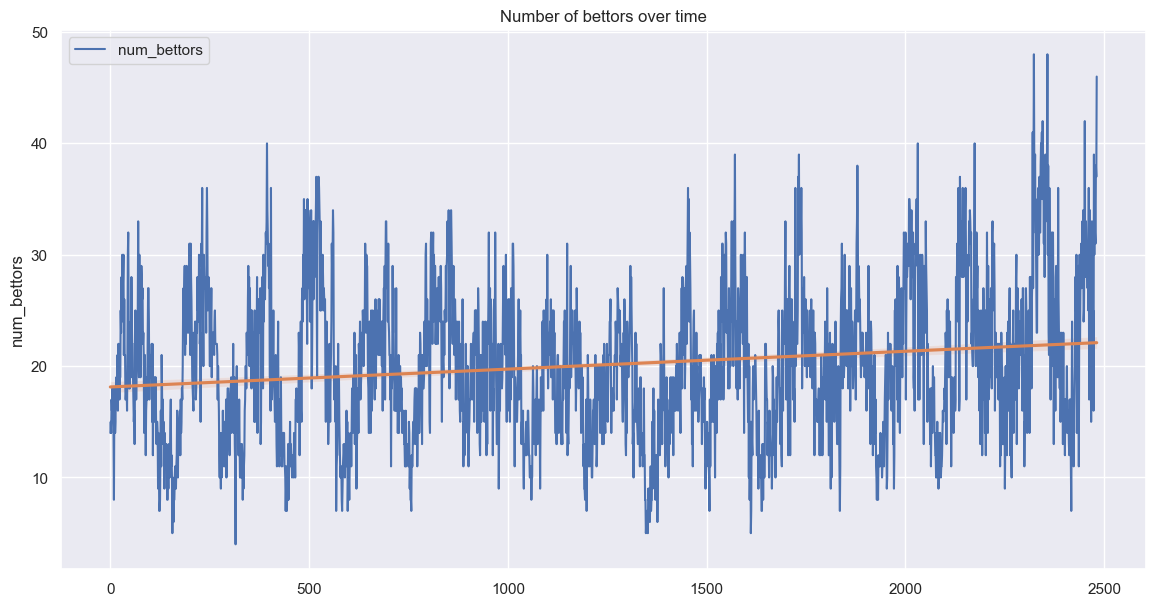

In [8]:
ax = data.plot(y="num_bettors",figsize=(14,7), title="Number of bettors over time")
sns.regplot(x=data.index, y=data.num_bettors, scatter=False, ax=ax)
plt.show()

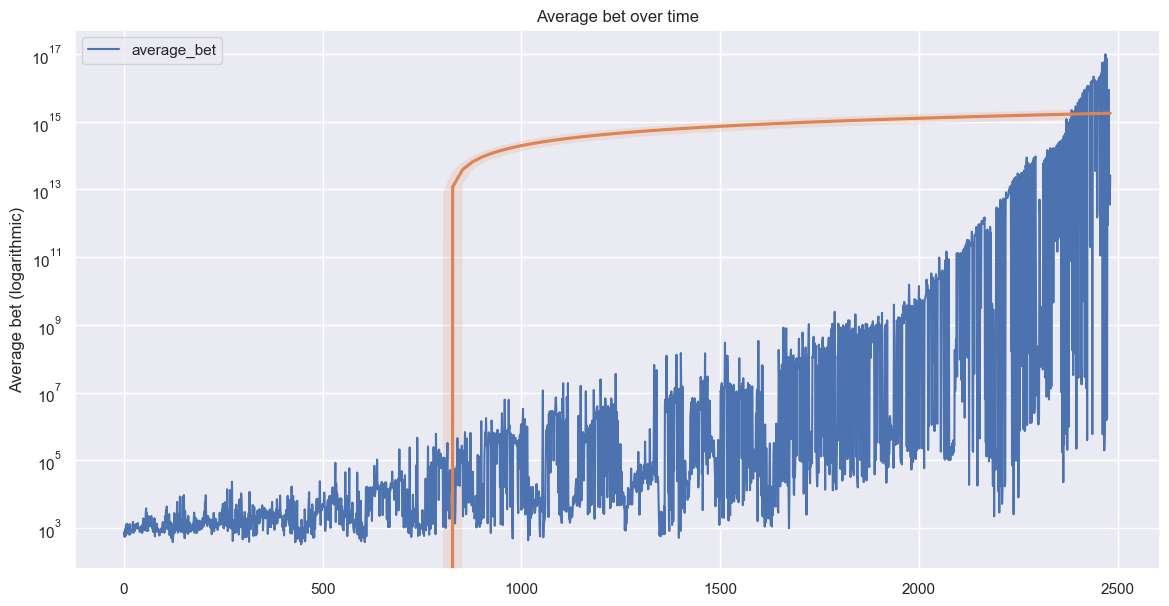

In [9]:
ax = nonzero_bets.plot(y="average_bet", logy=True, figsize=(14,7), title="Average bet over time")
sns.regplot(x=nonzero_bets.index, y=nonzero_bets.average_bet, scatter=False, ax=ax)
ax.set(ylabel="Average bet (logarithmic)")
plt.show()

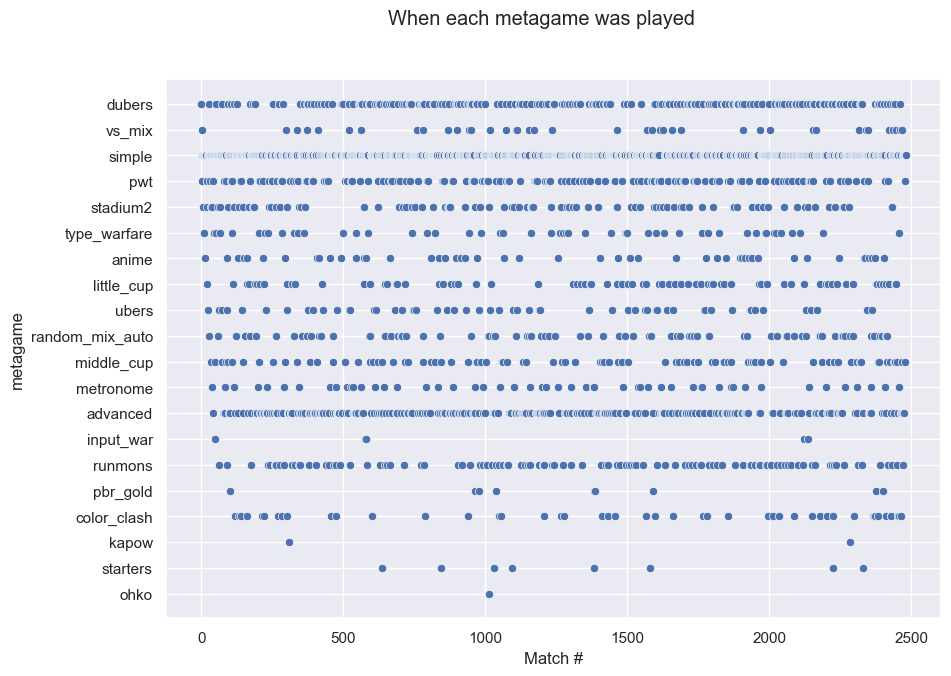

In [10]:
f = plt.figure(figsize=(10,7))
f.suptitle("When each metagame was played")
ax = sns.scatterplot(x=data.index,y=data.metagame)
ax.set(xlabel="Match #")
plt.show()

# Metagames

## Setup

In [11]:
threshold = 0.005 * data.index.max() # remove metagames that appear less than this amount of times, since they are likely token matches
meta = nonzero_bets[nonzero_bets.groupby("metagame").metagame.transform("count") > threshold]
metagames = nonzero_bets.metagame.unique().tolist()
for m in meta.metagame.unique().tolist():
    metagames.remove(m)
print("removed very rare metagames: " + str(metagames))

removed very rare metagames: ['input_war', 'pbr_gold', 'kapow', 'starters', 'ohko']


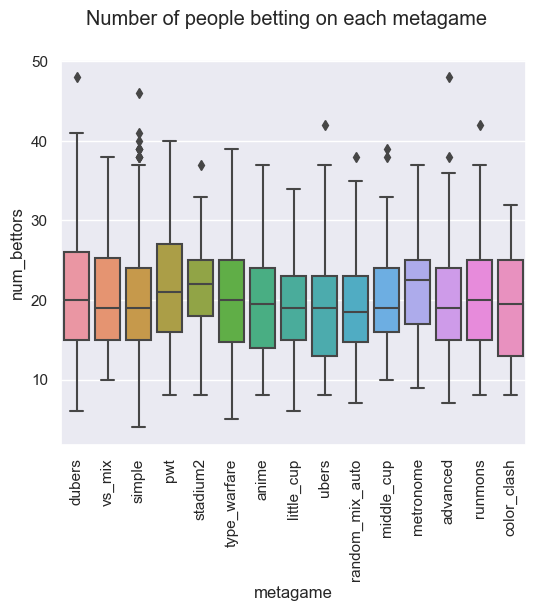

In [12]:
f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
f.suptitle("Number of people betting on each metagame")
sns.boxplot(x=meta.metagame, y=meta.num_bettors)
plt.xticks(rotation=90)
plt.show()

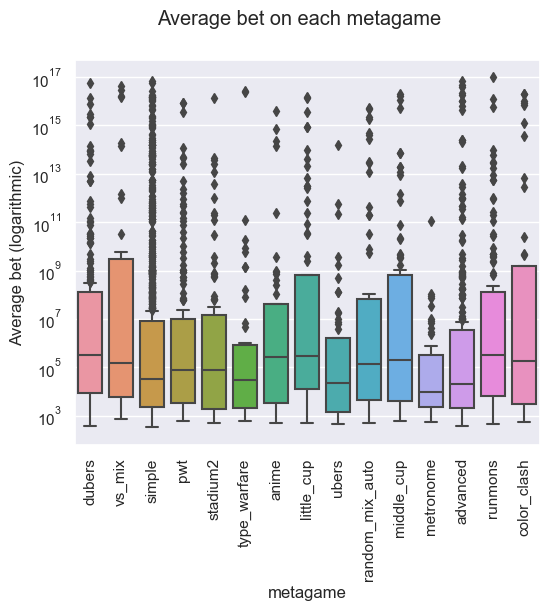

In [13]:
f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
f.suptitle("Average bet on each metagame")
ax = sns.boxplot(x=meta.metagame,y=meta.average_bet)
ax.set(yscale="log", ylabel="Average bet (logarithmic)")
plt.xticks(rotation=90)
del meta
plt.show()

# Gimmicks

## Setup

In [14]:
threshold_gim = 5 # absolute minimum amount of data we need to make any meaningful insight
gim = nonzero_bets[nonzero_bets.groupby("gimmick").gimmick.transform("count") > threshold_gim]
gimmicks = data.gimmick.unique().tolist()
for g in gim.gimmick.unique().tolist():
    gimmicks.remove(g)
print("removed infrequently used gimmicks: " + str(gimmicks))

removed infrequently used gimmicks: ['japanese', 'doubles_inputting_combo_of_4', 'armor', 'lucky', 'fire_and_ice', 'letdown', 'spanish', 'french', 'italian', 'sketchy', 'shield', 'doubles_defiance_combo_of_4']


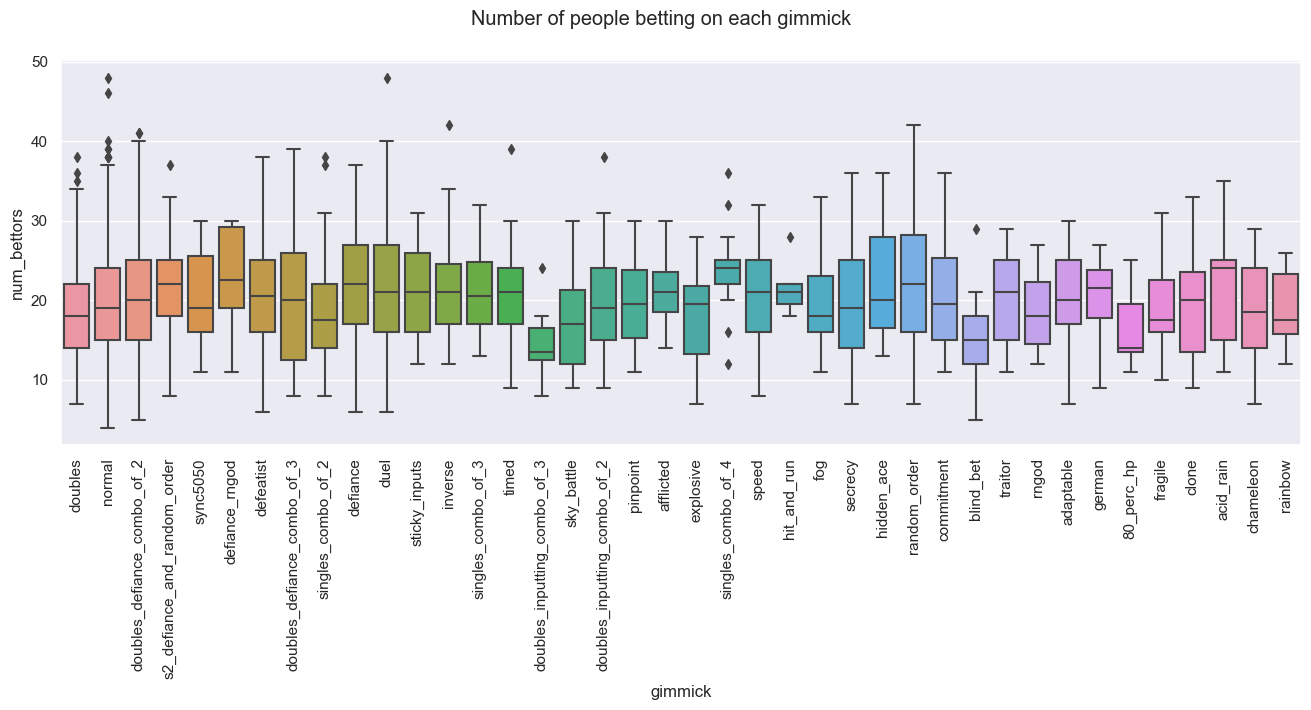

In [15]:
f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
f.suptitle("Number of people betting on each gimmick")
sns.boxplot(x="gimmick",y="num_bettors",data=gim)
plt.xticks(rotation=90)
plt.show()

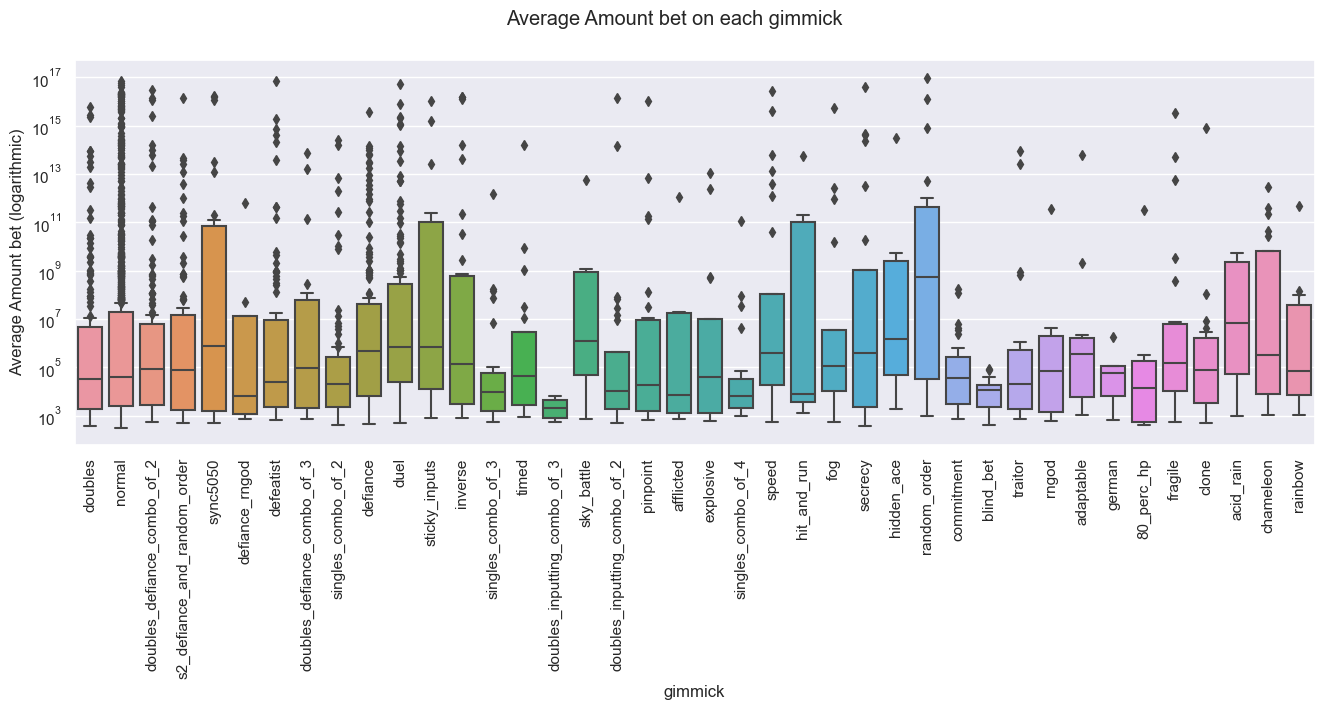

In [16]:
f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
f.suptitle("Average Amount bet on each gimmick")
ax = sns.boxplot(x=gim.gimmick, y=gim.average_bet)
ax.set(yscale="log", ylabel="Average Amount bet (logarithmic)")
plt.xticks(rotation=90)
del gim
plt.show()

# Switching

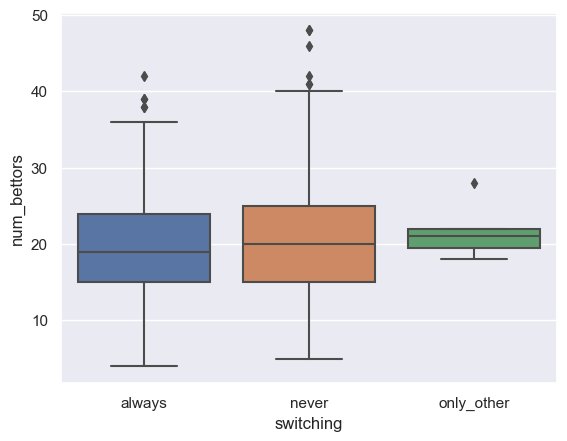

In [17]:
sns.boxplot(x=data.switching,y=data.num_bettors)
plt.show()

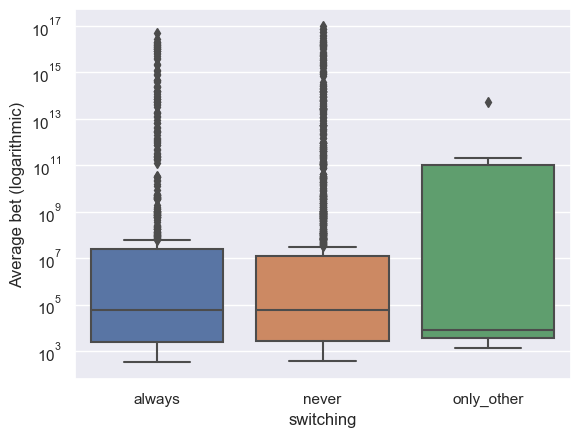

In [18]:
ax = sns.boxplot(x=data.switching,y=data.average_bet)
ax.set(yscale="log", ylabel="Average bet (logarithmic)")
plt.show()

# Odds vs winner
lower odds(<1) indicate more people bet on team 0 (probably red?), while higher(>1) odds indicate more people bet on team 1 (probably blue) 

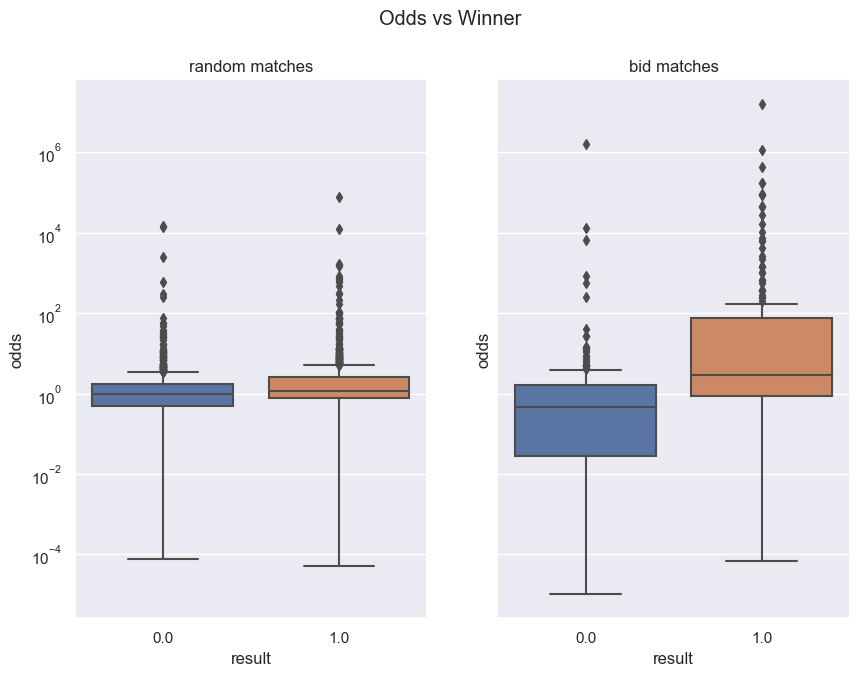

In [19]:
# remove entries where bets are all on 1 team
nonzero_bets = nonzero_bets[nonzero_bets.odds > 0.00001]

auto_matches = nonzero_bets[nonzero_bets.custom == False]
bid_matches = nonzero_bets[nonzero_bets.custom == True]

f, ax = plt.subplots(1, 2, figsize=(10,7),sharey=True)
f.suptitle("Odds vs Winner")
ax[0].set(yscale="log", title="random matches")
ax[1].set(title="bid matches")

sns.boxplot(x=auto_matches.result,y=auto_matches.odds, ax=ax[0])
sns.boxplot(x=bid_matches.result,y=bid_matches.odds)

plt.show()

# Bet bonus

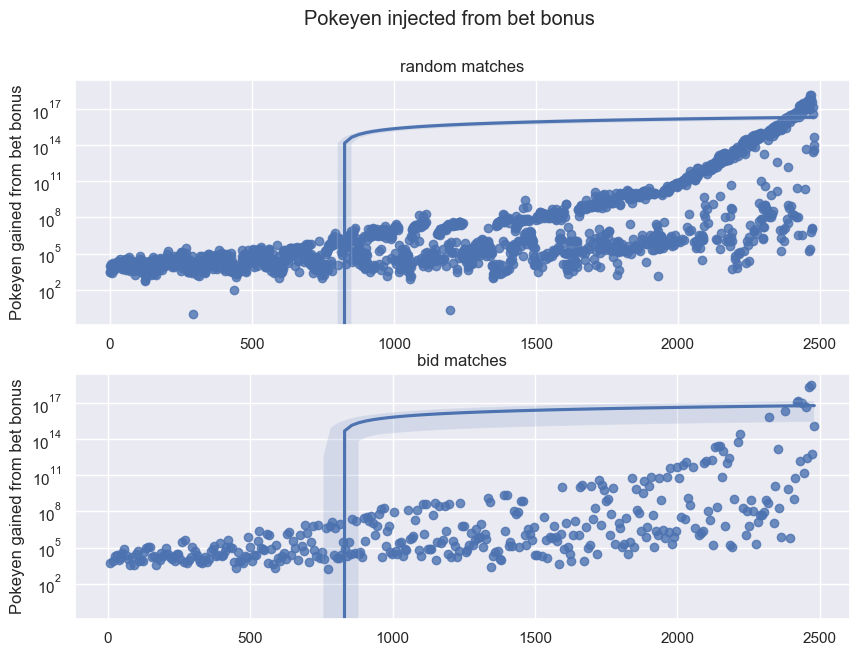

In [20]:
f, ax = plt.subplots(2, 1, figsize=(10,7),sharey=True)
f.suptitle("Pokeyen injected from bet bonus")
ax[0].set(yscale="log", title="random matches")
ax[1].set(title="bid matches")

sns.regplot(x=auto_matches.index,y=auto_matches.bet_bonus_amount, ax=ax[0])
sns.regplot(x=bid_matches.index,y=bid_matches.bet_bonus_amount)

ax[0].set(ylabel="Pokeyen gained from bet bonus")
ax[1].set(ylabel="Pokeyen gained from bet bonus")

plt.show()